In [ ]:
import os
import shutil
import pickle
import string
import pandas as pd
from google.colab import drive

In [ ]:

curr_folder = '/content/drive'
drive.mount(curr_folder)


start_dir = curr_folder + '/MyDrive/NN/Pictures/'
end_dir = curr_folder + '/MyDrive/NN/End/'

path_captions = curr_folder + '/MyDrive/NN/russiancap.csv'
path_captions_no_puncts = curr_folder + '/MyDrive/NN/nopunctsrussiancap.csv'

path_train = curr_folder + '/MyDrive/NN/train.csv'
path_val = curr_folder + '/MyDrive/NN/validation.csv'
path_test = curr_folder + '/MyDrive/NN/test.csv'

path_features = curr_folder + '/MyDrive/NN/features.pkl'
path_vocab = curr_folder + '/MyDrive/NN/vocab.pkl'
path_sentences = curr_folder + '/MyDrive/NN/sentences.pkl'

path_train_dict = curr_folder + '/MyDrive/NN/train_dict.pkl'
path_val_dict = curr_folder + '/MyDrive/NN/val_dict.pkl'


Mounted at /content/drive


# Удалить длинные предложения

In [ ]:
df = pd.read_csv(path_captions, sep='|')

In [ ]:
df.head()

,image_name,comment_number,comment
0,1.jpg,0.0,Двое детей гуляют по деревне.
1,1.jpg,1.0,Двое детей гуляют по деревне.
2,1.jpg,2.0,Ребенок в синей рубашке.
3,1.jpg,3.0,Двое детей играют.
4,1.jpg,4.0,Стоят двое детей.


In [ ]:
df.iat[0,2]

'Двое детей гуляют по деревне.'

In [ ]:
idxs_to_del = []

for idx in df.index:
    curr_len = len(str(df.iat[idx, 2]))
    if curr_len > 100 or curr_len==0 or str(df.iat[idx, 2])==None:
        idxs_to_del.append(idx)

df_to_delete = df.loc[idxs_to_del, :]
images_to_delete = df_to_delete["image_name"].unique()

In [ ]:
print(df.shape)
df = df[~df.image_name.isin(images_to_delete)]
print(df.shape)

(39105, 3)
(37717, 3)


# Подготовка данных к обучению

– Каждое слово с маленькой буквы
– Удалить знаки препинания
– Только буквы

In [ ]:
def clean_captions(data):
    table = str.maketrans('', '', string.punctuation)

    for idx in data.index:
        curr_capt = str(data.iat[idx, 2])
        curr_capt = curr_capt.split()
        curr_capt = [word.lower() for word in curr_capt]
        curr_capt = [word.translate(table) for word in curr_capt]
        curr_capt = [word for word in curr_capt if word.isalpha()]

        data.iat[idx, 2] = ' '.join(curr_capt)

In [ ]:
df = pd.read_csv(path_captions, delimiter='|')
df.head(5)

,image_name,comment_number,comment
0,1.jpg,0.0,Двое детей гуляют по деревне.
1,1.jpg,1.0,Двое детей гуляют по деревне.
2,1.jpg,2.0,Ребенок в синей рубашке.
3,1.jpg,3.0,Двое детей играют.
4,1.jpg,4.0,Стоят двое детей.


In [ ]:
clean_captions(df)
df.head()

,image_name,comment_number,comment
0,1.jpg,0.0,двое детей гуляют по деревне
1,1.jpg,1.0,двое детей гуляют по деревне
2,1.jpg,2.0,ребенок в синей рубашке
3,1.jpg,3.0,двое детей играют
4,1.jpg,4.0,стоят двое детей


In [ ]:
df.to_csv(path_captions_no_puncts, sep='|', encoding='utf-8', index=False)

In [ ]:
#%% md
# Словарь
#%%
def to_vocab(data):
  vocab = set()
  for idx in data.index:
    vocab.update(str(data.iat[idx, 2]).split())
  return vocab
#%%
df = pd.read_csv(path_captions_no_puncts, sep='|')
vocab = to_vocab(df)
print('размер словаря ... %d' % len(vocab))
#%%
with open(path_vocab,'wb') as f:
  pickle.dump(vocab, f)
#%%
with open(path_vocab,'rb') as f:
  loaded_vocab = pickle.load(f)
#%% md
# Разбить набор на три части

размер словаря ... 12471


In [ ]:
# Features

def to_features(data):
  features = dict()
  start_index = 0
  end_index = len(data) - 1 - 5
  for idx in range(start_index, end_index+1, 5):
    image_name = str(data.iat[idx, 0])[:-4]
    curr_list = list()
    curr_list.append(data.iat[idx, 2])
    curr_list.append(data.iat[idx+1, 2])
    curr_list.append(data.iat[idx+2, 2])
    curr_list.append(data.iat[idx+3, 2])
    curr_list.append(data.iat[idx+4, 2])
    words = list()
    for sent in curr_list:
      for word in str(sent).split():
        words.append(word)
    features[image_name] = ' '.join(set(words))
  return features

In [ ]:
df = pd.read_csv(path_captions_no_puncts, sep='|')
features = to_features(df)

In [ ]:
print(features["1"])

по деревне стоят синей гуляют двое детей рубашке ребенок играют в


In [ ]:
print('размер признаков ... %d' % len(features))
with open(path_features,'wb') as f:
  pickle.dump(features, f)

with open(path_features,'rb') as f:
  loaded_features = pickle.load(f)

размер признаков ... 7796


# Разбить набор на три части

In [ ]:
df = pd.read_csv(path_captions_no_puncts, delimiter='|')
df.head(5)

,image_name,comment_number,comment
0,1.jpg,0.0,двое детей гуляют по деревне
1,1.jpg,1.0,двое детей гуляют по деревне
2,1.jpg,2.0,ребенок в синей рубашке
3,1.jpg,3.0,двое детей играют
4,1.jpg,4.0,стоят двое детей


In [ ]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.to_csv(path_train, sep='|', encoding='utf-8', index=False)
val_df.to_csv(path_val, sep='|', encoding='utf-8', index=False)
test_df.to_csv(path_test, sep='|', encoding='utf-8', index=False)

# Добавить начальные и конечные строки startseq и endseq

In [ ]:
def add_start_end_tags(data):
    for idx in data.index:
        curr_str = str(data.iat[idx, 2])
        data.iat[idx, 2] = 'startseq ' + curr_str + ' endseq'

In [ ]:
train_df = pd.read_csv(path_train, sep='|')
val_df = pd.read_csv(path_val, sep='|')
test_df = pd.read_csv(path_test, sep='|')

add_start_end_tags(train_df)
add_start_end_tags(val_df)
add_start_end_tags(test_df)

train_df.to_csv(path_train, sep='|', encoding='utf-8', index=False)
val_df.to_csv(path_val, sep='|', encoding='utf-8', index=False)
test_df.to_csv(path_test, sep='|', encoding='utf-8', index=False)

In [ ]:
test_df.iat[0, 2]

'startseq женщина стоит с кирпичом в руке endseq'

# Конвертация pandas.dataframe в dict

In [ ]:
def to_dict(data):
    out_dict = dict()

    start_index = 0
    end_index = len(data) - 1 - 5

    for idx in range(start_index, end_index+1, 5):
        image_name = str(data.iat[idx, 0])[:-4]
        curr_list = list()

        curr_list.append(data.iat[idx, 2])
        curr_list.append(data.iat[idx+1, 2])
        curr_list.append(data.iat[idx+2, 2])
        curr_list.append(data.iat[idx+3, 2])
        curr_list.append(data.iat[idx+4, 2])

        out_dict[image_name] = curr_list

    return out_dict

In [ ]:
df_to_convert = pd.read_csv(path_val, sep='|')
df_to_convert.head()

,image_name,comment_number,comment
0,5614.jpg,27373.0,startseq стоит пожилая женщина за ней сидит ст...
1,5614.jpg,27374.0,startseq в жестяной комнате стоит старик за ни...
2,5614.jpg,27375.0,startseq стоит старуха а рядом с ней на скамей...
3,5614.jpg,27376.0,startseq стоит старуха а на пустой кровати сид...
4,5614.jpg,27377.0,startseq в жестяной комнате старуха с платком ...


In [ ]:
new_dict = to_dict(df_to_convert)

In [ ]:
with open(path_val_dict,'wb') as f:
    pickle.dump(new_dict, f)

In [ ]:
with open (path_val_dict, 'rb') as f:
    test_dict = pickle.load(f)

In [ ]:
df_to_convert = pd.read_csv(path_train, sep='|')
df_to_convert.head()



,image_name,comment_number,comment
0,1.jpg,0.0,startseq двое детей гуляют по деревне endseq
1,1.jpg,1.0,startseq двое детей гуляют по деревне endseq
2,1.jpg,2.0,startseq ребенок в синей рубашке endseq
3,1.jpg,3.0,startseq двое детей играют endseq
4,1.jpg,4.0,startseq стоят двое детей endseq


In [ ]:
new_dict = to_dict(df_to_convert)
with open(path_train_dict,'wb') as f:
    pickle.dump(new_dict, f)
with open (path_train_dict, 'rb') as f:
    test_dict = pickle.load(f)

In [ ]:
#%% md
# Предложения для обучения
#%%
def to_sentences(data):
  all_sentences = list()
  for idx in data.index:
    all_sentences.append(data.iat[idx, 2])
  return all_sentences
#%%
train_df = pd.read_csv(path_train, delimiter='|')
sentences = to_sentences(train_df)
print(len(sentences))
#%%
with open(path_sentences, 'wb') as f:
  pickle.dump(sentences, f)
#%%
with open (path_sentences, 'rb') as f:
  list_sentences = pickle.load(f)

27373


# Выбрать и скопировать изображения

In [ ]:
df = pd.read_csv(path_captions, sep='|')

images_unique = df["image_name"].unique()
#print(images_unique.shape)
#print(df.shape)

In [ ]:
for image_name in images_unique:

    curr_image = start_dir + str(image_name)
    copied_image = end_dir + str(image_name)
    print(f"cur {curr_image}, cop {copied_image}")
    try:
      shutil.copy2(curr_image, copied_image)
    except:
      pass

counter = len(os.listdir(path=end_dir))
print("скопировано изображений ... " + str(counter))

# Этап 2
Создание моделей

In [ ]:
import os
import pickle
import random
import time
import numpy as np

from tensorflow.python.client import device_lib
from keras.layers import RepeatVector, TimeDistributed, Bidirectional

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.image import load_img, img_to_array

from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from google.colab import drive

In [ ]:
curr_folder = '/content/drive'
drive.mount(curr_folder)


start_dir = curr_folder + '/MyDrive/NN/Pictures/'
end_dir = curr_folder + '/MyDrive/NN/End/'


path_tokenizer = curr_folder + '/MyDrive/NN/tokenizer.pkl'
path_train_dict = curr_folder + '/MyDrive/NN/train_dict.pkl'
path_val_dict = curr_folder + '/MyDrive/NN/val_dict.pkl'

path_features_vgg16 = curr_folder + '/MyDrive/NN/vocab.pkl'
path_features_inception = curr_folder + '/MyDrive/NN/features.pkl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка

In [ ]:
def image_names_set(data):
    vals = set()

    for idx in data.index:
        vals.add(data.iat[idx, 0][:-4])

    return vals

def load_image_features(filename, data):
    all_features = pickle.load(open(filename, 'rb'))
    features = {k: all_features[k] for k in data}

    return features

Закодировать знаки в числа
Модель, которую мы разработаем, будет генерировать подпись к фотографии, и подпись будет генерироваться по одному слову за раз.

Последовательность ранее сгенерированных слов будет предоставлена в качестве входных данных. Поэтому нам понадобится "первое слово", чтобы начать процесс генерации, и "последнее слово", чтобы сигнализировать об окончании подписи. Для этой цели мы будем использовать строки "startseq" и "endseq". Эти маркеры добавляются к загруженным описаниям по мере их загрузки. Важно сделать это сейчас, прежде чем мы закодируем текст, чтобы токены также были закодированы правильно.

Текст подписи необходимо будет закодировать в числа, прежде чем его можно будет представить модели в качестве входных данных или сравнить с предсказаниями модели.

Первым шагом в кодировании данных является создание согласованного сопоставления слов с уникальными целочисленными значениями. Keras предоставляет класс Tokenizer, который может изучить это сопоставление из загруженных данных описания.

Каждое описание будет разделено на слова. Модель будет предоставлена одним словом и фотографией и сгенерирует следующее слово. Затем первые два слова описания будут предоставлены модели в качестве входных данных вместе с изображением для создания следующего слова. Именно так будет обучаться модель.

In [ ]:
def to_lines(data):
    all_vals = list()
    for key in data.keys():
        [all_vals.append(d) for d in data[key]]

    return all_vals

def create_tokenizer(data):
    lines = to_lines(data)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)

    return tokenizer

def find_max_words(data):
    lines = to_lines(data)
    return max(len(l.split()) for l in lines)

Создание последовательности
Приведенная ниже функция с именем create_sequences(), учитывая токенизатор, максимальную длину последовательности и словарь всех описаний и фотографий, преобразует данные в пары ввода-вывода данных для обучения модели.

В модели есть два входных массива: один для признаков фотографии и один для закодированного текста. Существует один вывод для модели, который представляет собой закодированное следующее слово в текстовой последовательности.

Входной текст кодируется в виде целых чисел, которые будут передаваться на слой встраивания слов. Признаки изображения будут передаваться непосредственно в другую часть модели. Модель выдаст прогноз, который будет представлять собой распределение вероятностей по всем словам в словаре.

Таким образом, выходные данные будут представлять собой однократно закодированную версию каждого слова, представляющую идеализированное распределение вероятностей со значениями 0 во всех позициях слов, кроме фактической позиции слова, которая имеет значение 1.

X1, X2 (text sequence), y (word) photo startseq, little photo startseq, little, girl photo startseq, little, girl, running photo startseq, little, girl, running, in photo startseq, little, girl, running, in, field photo startseq, little, girl, running, in, field, endseq

In [ ]:
def create_sequences(tokenizer, max_words, captions_list, image_name):
    X_image, X_text, y_word = list(), list(), list()
    vocab_size = len(tokenizer.word_index) + 1

    for caption in captions_list:
        seq = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_words)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            X_image.append(image_name)
            X_text.append(in_seq)
            y_word.append(out_seq)

    return X_image, X_text, y_word

Генератор данных
Генератор данных будет выдавать данные на одно изображении в каждой партии. Это будут все последовательности, сгенерированные для изображения и её набора описаний.

Функция data_generator() будет генератором данных и будет принимать загруженные текстовые описания, признаки изображений, токенизатор и максимальную длину.

Вы можете видеть, что мы вызываем функцию create_sequence (), чтобы создать пакет данных для одного изображения, а не для всего набора данных. Это означает, что мы должны обновить функцию create_sequences (), чтобы удалить “итерацию по всем описаниям” для цикла.

Генератор данных, предназначен для использования в вызове model.fit_generator().

Обратите внимание, что это очень простой генератор данных. Большая экономия памяти, которую он предлагает, заключается в том, чтобы не иметь развернутых последовательностей обучающих и тестовых данных в памяти до подгонки модели, чтобы эти образцы (например, результаты create_sequences()) создавались по мере необходимости для каждого изображения.

In [ ]:
def data_generator(tokenizer, max_words, data, images, batch_size, random_seed):
    count = 0
    random.seed(random_seed)

    img_names = list(data.keys())
    assert batch_size <= len(img_names), 'batch size must be less than or equal to {}'.format(len(img_names))

    while True:
        input_img_batch, input_seq_batch, output_word_batch = list(), list(), list()

        if count >= len(img_names):
            count = 0
        start_i = count
        end_i = min(len(img_names), count + batch_size)

        for i in range(start_i, end_i):
            curr_img = img_names[i]
            image = images[curr_img][0]
            captions_list = data[curr_img]
            random.shuffle(captions_list)

            input_img, input_seq, output_word = create_sequences(tokenizer, max_words, captions_list, image)

            for j in range(len(input_img)):
                input_img_batch.append(input_img[j])
                input_seq_batch.append(input_seq[j])
                output_word_batch.append(output_word[j])

        count = count + batch_size
        yield [np.array(input_img_batch), np.array(input_seq_batch)], np.array(output_word_batch)

Построение модели
Мы опишем модель в трёх частях:

1 – Извлечение признаков изображения. Это 16-слойная модель VGG, предварительно обученная на наборе данных ImageNet. Мы предварительно обработали изображения с помощью модели VGG (без выходного слоя) и будем использовать извлечённые признаки, предсказанные этой моделью, в качестве входных данных.

2 – Обработка последовательностей. Это слой встраивания слов для обработки ввода текста, за которым следует слой рекуррентной нейронной сети с длительной кратковременной памятью (LSTM).

3 – Расшифровка. (1) и (2) выводят вектор фиксированной длины. Они объединяются вместе и обрабатываются плотным слоем, чтобы сделать окончательный прогноз.

Модель (1) ожидает, что входные признаки изображений будут вектором из 4096 элементов. Они обрабатываются плотным слоем для получения 256-элементного представления изображения.

Модель (2) ожидает входные последовательности с заранее определённой длиной, которые подаются в слой встраивания, использующий маску для игнорирования дополненных значений. За этим следует слой LSTM с 256 единицами памяти.

Обе входные модели создают вектор из 256 элементов. Кроме того, обе входные модели используют регуляризацию в виде 50% отсева (dropout). Это делается для того, чтобы уменьшить переобучение модели на текущем наборе данных, так как эта конфигурация модели обучается очень быстро.

Модель (3) объединяет векторы из обеих входных моделей с помощью операции сложения. Затем этот вектор подаётся на плотный слой из 256 нейронов, а затем на конечный выходной плотный слой, который делает прогноз softmax по всему выходному словарю для следующего слова в последовательности.

In [ ]:
def build_rnn(input_size, vocab_size, max_words):
    inputs1 = Input(shape=(input_size,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_words,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    de1 = add([fe2, se3])
    de2 = Dense(256, activation='relu')(de1)
    outputs = Dense(vocab_size, activation='softmax')(de2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [ ]:
def build_alt_rnn(input_size, vocab_size, max_words):
    image_input = Input(shape=(input_size,))
    fe1 = Dense(256, activation='relu')(image_input)
    image_model = RepeatVector(max_words)(fe1)

    caption_input = Input(shape=(max_words,))
    # we zero pad inputs to the same length, the zero mask ignores those inputs
    se1 = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
    # since we are going to predict the next word using the previous words
    # (length of previous words changes with every iteration over the caption), we have to set return_sequences = True
    se2 = LSTM(256, return_sequences=True)(se1)
    caption_model = TimeDistributed(Dense(256))(se2)

    # merging the models and creating a softmax classifier
    de1 = add([image_model, caption_model])
    de2 = Bidirectional(LSTM(256, return_sequences=False))(de1)
    final_model = Dense(vocab_size, activation='softmax')(de2)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

Обучение
В этом примере мы отбросим загрузку тестового набора данных и контрольные точки модели и просто сохраним модель после каждой эпохи обучения. Затем мы сможем вернуться и загрузить/оценить каждую сохраненную модель после обучения, чтобы найти ту, которая имеет наименьшие потери.

In [ ]:
def load_train_data(train_dict_path, tokenizer_path, features_path):
    with open (train_dict_path, 'rb') as f:
        out_train_dict = pickle.load(f)
    print('кол-во подписей .............. %d' % len(out_train_dict))

    del out_train_dict[""]

    out_train_features = load_image_features(features_path, out_train_dict)

    with open (tokenizer_path, 'rb') as f:
        out_tokenizer = pickle.load(f)
    out_vocab_size = len(out_tokenizer.word_index) + 1
    print('размер словаря ............... %d' % out_vocab_size)

    out_max_words = find_max_words(out_train_dict)
    print('длина предложения в словах ... %d' % out_max_words)

    return out_train_dict, out_tokenizer, out_vocab_size, out_max_words, out_train_features

model_path = curr_folder + '/MyDrive/NN/Inspiration2/'
def train_model(model, train_dict, tokenizer, max_words, train_features, batch_size, epochs_num):
    steps = len(train_dict)/batch_size
    if len(train_dict) % batch_size != 0:
        steps = steps + 1

    start_time = time.time()
    for i in range(epochs_num):
        generator = data_generator(tokenizer, max_words, train_dict, train_features, batch_size, 42)
        model.fit(generator,
                  epochs=1, steps_per_epoch=steps,
                  verbose=1)
        model.save(model_path + 'Inspiration2-' + str(i) + '.h5')

    time_difference = time.time() - start_time
    minutes = time_difference/60
    print('время обучения в минутах ..... %d' % minutes)

Набор для обучения 

In [ ]:
batch_size = 16
epochs_num = 20
train_dict, tokenizer, vocab_size, max_words, train_features = load_train_data(path_train_dict, path_tokenizer, path_features_inception)

кол-во подписей .............. 5456
размер словаря ............... 21391
длина предложения в словах ... 30


Обучение VGG16

In [ ]:
model = build_rnn(2048, vocab_size, max_words)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 30, 256)      5476096     ['input_12[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 4096)         0           ['input_11[0][0]']               
                                                                                            

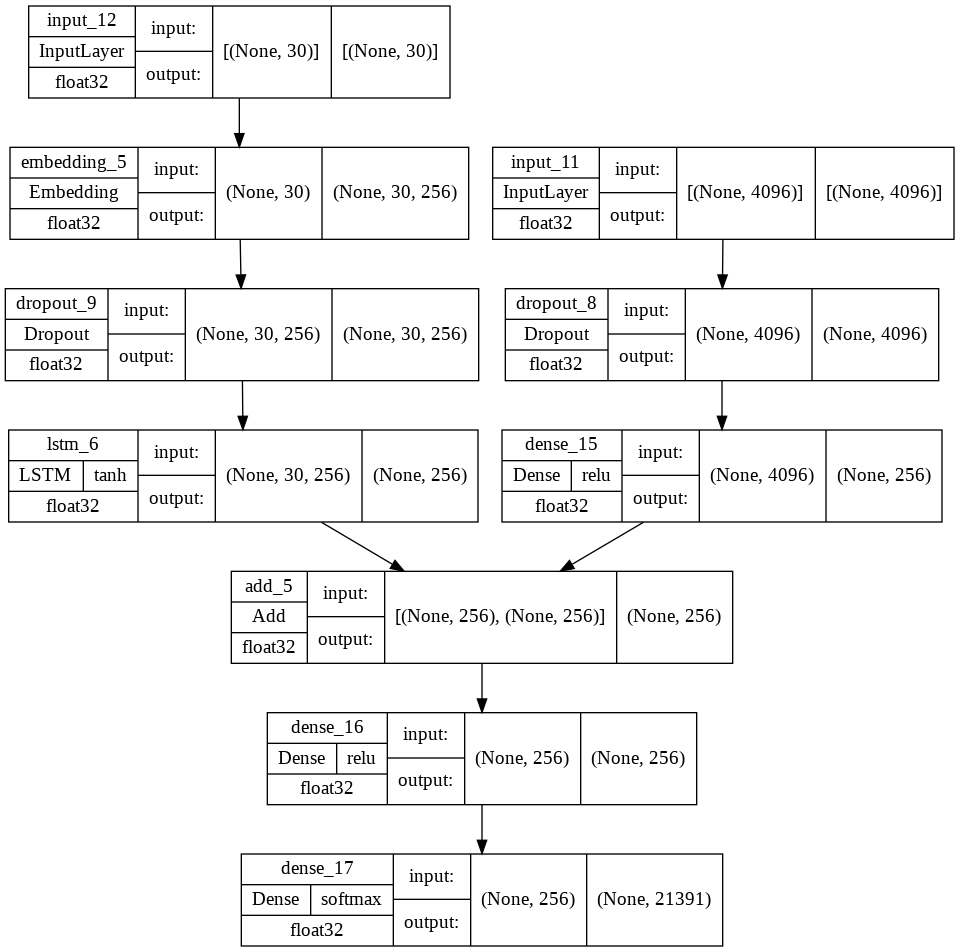

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file=curr_folder+'/MyDrive/NN/model.png', show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
train_model(model, train_dict, tokenizer, max_words, train_features, batch_size, epochs_num)

341/341 [==============================] - 635s 2s/step - loss: 2.4396
время обучения в минутах ..... 224


In [ ]:
model = build_alt_rnn(2048, vocab_size, max_words)
train_model(model, train_dict, tokenizer, max_words, train_features, batch_size, epochs_num)

# **Обучение Inception**

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_i

def extract_features_inception(directory):
    model = InceptionV3(weights="imagenet")
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    features = dict()
    for name in os.listdir(directory):
        filename = directory + '/' + name

        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input_i(image)

        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature

    return features

In [ ]:
%%time
features = extract_features_inception(end_dir)
print('выделенные признаки ... %d' % len(features))
pickle.dump(features, open(path_features_inception, 'wb'))

выделенные признаки ... 8000
CPU times: user 56min 39s, sys: 1min 40s, total: 58min 19s
Wall time: 34min 36s


In [ ]:
train_dict, tokenizer, vocab_size, max_words, train_features = load_train_data(path_train_dict, path_tokenizer, path_features_inception)

кол-во подписей .............. 5456
размер словаря ............... 21391
длина предложения в словах ... 30


In [ ]:
model = build_rnn(2048, vocab_size, max_words)
train_model(model, train_dict, tokenizer, max_words, train_features, batch_size, epochs_num)

341/341 [==============================] - 649s 2s/step - loss: 2.4266
время обучения в минутах ..... 224


In [ ]:
model = build_alt_rnn(2048, vocab_size, max_words)
train_model(model, train_dict, tokenizer, max_words, train_features, batch_size, epochs_num)